In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances


import sys
sys.path.append("../..")
from util.features import build_featureset
from util.author_vis import t_sne, pca
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [2]:
test_data = pd.read_pickle('../../data/04-0c_Test_Set.pkl')

# Prototype Featureset as Style Embedding

Goal: Model the style of committers by creating a self-built style embedding including features like length, polarity, and others that were explored earlier.

### Construct First Feature Set

A first feature set is set up with the length and the amount of point characters of a message to learn how to do the implementation.

In [3]:
import numpy as np

simple_feature_set = []

for message in test_data['message']:
    number_of_chars         = len(message)
    point_count             = message.count(".")
    simple_feature_set.append([number_of_chars, point_count])

simple_feature_set = np.array(simple_feature_set)

In [4]:
simple_feature_set

array([[275,   4],
       [ 89,   0],
       [131,   1],
       ...,
       [ 28,   0],
       [ 71,   0],
       [107,   0]])

### Construct Complex Feature Set

A second featureset containing more values is constructed by the corresponding function in features.py.

In [5]:
complex_featureset = build_featureset(test_data, normalize=False)

100%|██████████| 10684/10684 [06:45<00:00, 26.36it/s]


In [6]:
np.save('../../data/03a_Test_Set_Features', complex_featureset)

In [7]:
complex_featureset = np.load('../../data/03a_Test_Set_Features.npy', allow_pickle=True)

### Normalize

In [8]:
# vectors = simple_feature_set / np.linalg.norm(simple_feature_set)
vectors = complex_featureset / np.linalg.norm(complex_featureset)

## Centroids

In [9]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [10]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.index = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']
distances.columns = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,0.004,0.003,0.004,0.005,0.005,0.006
1,0.000,0.000,0.001,0.000,0.001,0.001,0.001
2,0.000,0.000,0.000,0.001,0.002,0.002,0.002
3,0.000,0.000,0.000,0.000,0.001,0.001,0.001
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

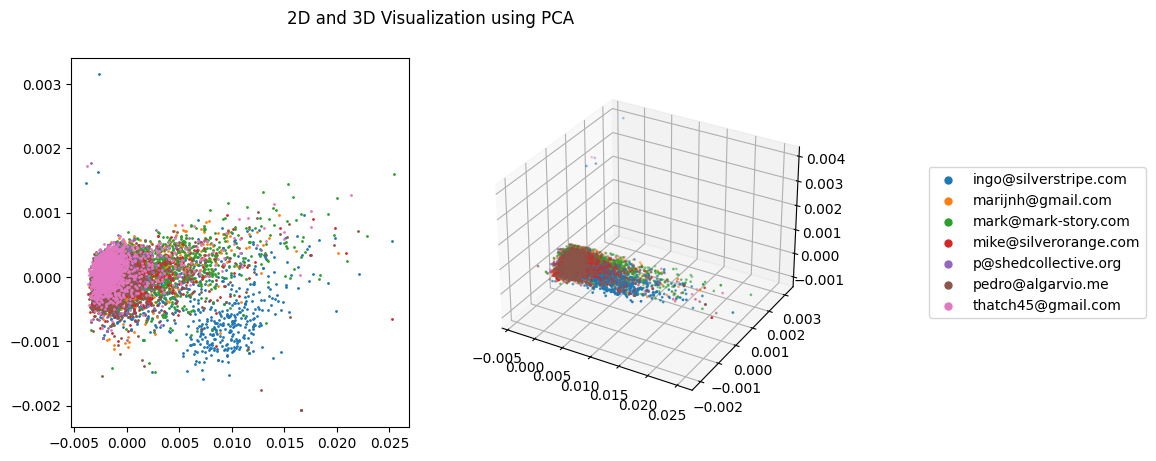

In [11]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

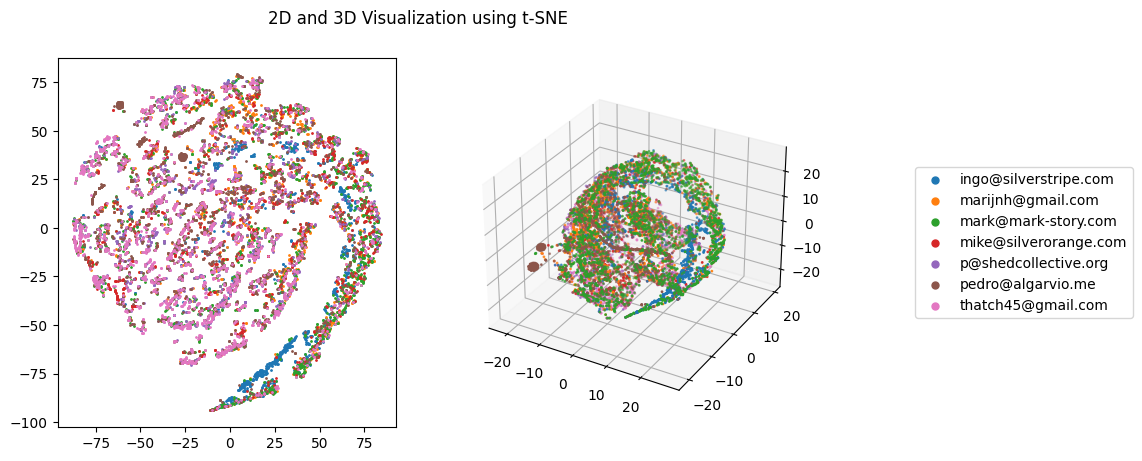

In [12]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

It can be seen that many SpaCy representations are similar and might be difficult to cluster. 

Anyways, below we try a density-based DBSCAN clustering and a centroid-based K-Means clustering to see if we can find clusters in the data.

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 1
10 Most common:
[(0, 10684)]


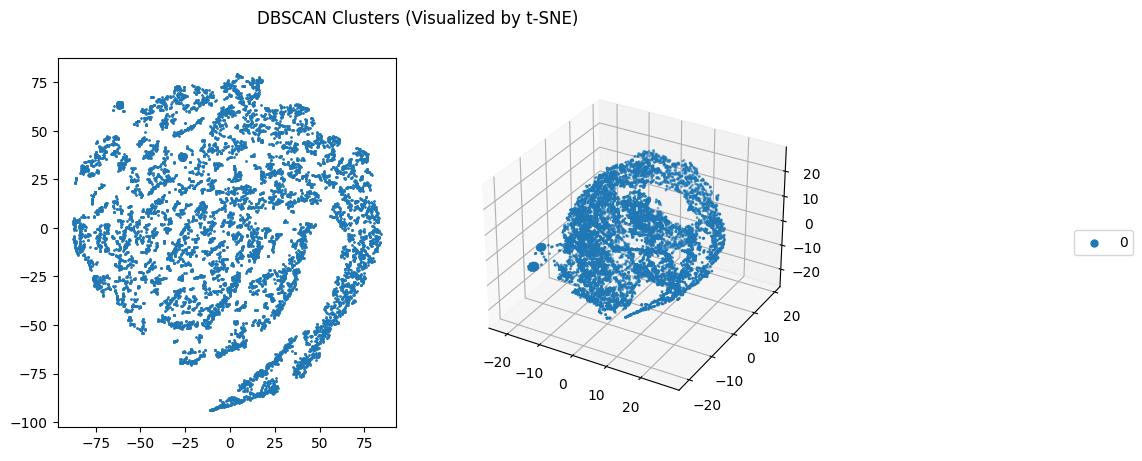

In [13]:
dbscan_model = DBSCAN(eps=2, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [14]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,10684.0,7.0,1500.0,"('mark@mark-story.com', 2082)",91.0,7.0,"('saltstack_salt', 3798)"


In [15]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,1.0,1.0,1.0,1.0,1.0
mean,10684.0,7.0,1500.0,91.0,7.0
std,NaN,NaN,NaN,NaN,NaN
min,10684.0,7.0,1500.0,91.0,7.0
25%,10684.0,7.0,1500.0,91.0,7.0
50%,10684.0,7.0,1500.0,91.0,7.0
75%,10684.0,7.0,1500.0,91.0,7.0
max,10684.0,7.0,1500.0,91.0,7.0


In [16]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0
length_mean,76.329745
length_std,57.726650
n_uppercase_mean,3.643205
n_uppercase_std,4.369493
polarity_mean,0.012540
polarity_std,0.179418
subjectivity_mean,0.191629
subjectivity_std,0.281966


In [17]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed due to the Member.PasswordEncyrption property changing from an ENUM to Varchar.

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
3) 
MINOR Protection against infinite initialization/callback loops caused by loading a full page template via ajax (in LeftAndMain.js)
___
4) 
Allowing success and error callbacks in refresh()
___
5) 
Better shell execution feedback from PDF extractor
___
6) 
BUGFIX: Make sure CMS link knows when its currently in the CMS (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
7) 
Added iShouldSeeAButton assertion
___
8) 
MINOR ArrayLib - removed unncessary extending of Objec

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(3, 3701), (0, 3629), (6, 1596), (5, 816), (1, 518), (4, 338), (2, 86)]


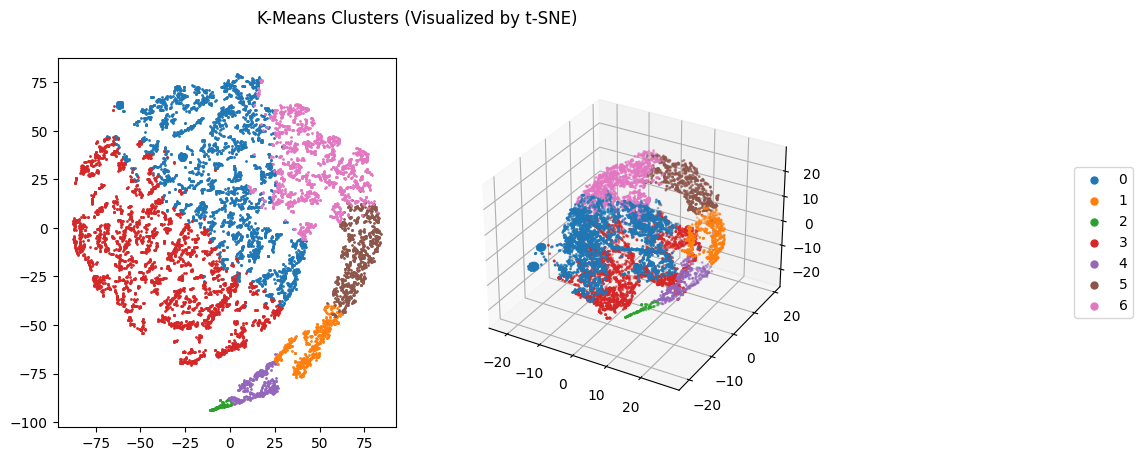

In [18]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [19]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,3629.0,7.0,528.0,"('pedro@algarvio.me', 857)",71.0,4.0,"('saltstack_salt', 1472)"
1,518.0,7.0,39.0,"('ingo@silverstripe.com', 178)",33.0,1.0,"('cakephp_cakephp', 163)"
2,86.0,6.0,8.0,"('ingo@silverstripe.com', 33)",12.0,2.0,"('cakephp_cakephp', 27)"
3,3701.0,7.0,498.0,"('thatch45@gmail.com', 1112)",73.0,5.0,"('saltstack_salt', 1803)"
4,338.0,7.0,17.0,"('ingo@silverstripe.com', 201)",20.0,1.5,"('silverstripe_silverstripe-framework', 134)"
5,816.0,7.0,107.0,"('mark@mark-story.com', 298)",40.0,2.0,"('cakephp_cakephp', 285)"
6,1596.0,7.0,208.0,"('mark@mark-story.com', 368)",55.0,2.0,"('cakephp_cakephp', 343)"


In [20]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.857143,200.714286,43.428571,2.500000
std,1536.404972,0.377964,224.117316,23.894610,1.443376
min,86.000000,6.000000,8.000000,12.000000,1.000000
25%,428.000000,7.000000,28.000000,26.500000,1.750000
50%,816.000000,7.000000,107.000000,40.000000,2.000000
75%,2612.500000,7.000000,353.000000,63.000000,3.000000
max,3701.000000,7.000000,528.000000,73.000000,5.000000


In [21]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6
length_mean,58.425186,190.162162,355.651163,37.180492,258.597633,133.113971,88.195489
length_std,7.303727,19.096199,44.619781,7.123101,22.512802,14.430717,10.556656
n_uppercase_mean,2.643703,9.027027,12.988372,1.880032,13.994083,6.117647,4.296366
n_uppercase_std,2.627950,5.934264,8.025387,2.077708,7.635558,4.693642,3.707239
polarity_mean,0.011560,0.019261,0.059222,0.010118,0.037724,0.007092,0.013139
polarity_std,0.170677,0.197651,0.181754,0.167423,0.198972,0.201841,0.200711
subjectivity_mean,0.167609,0.341633,0.411850,0.124442,0.385167,0.300712,0.244733
subjectivity_std,0.276873,0.268493,0.230768,0.254630,0.253808,0.280644,0.298087


In [22]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Allowing success and error callbacks in refresh()
___
2) 
Better shell execution feedback from PDF extractor
___
3) 
Calling destructor on fatal errors

Avoids leaving TESTS_RUNNING.js around
___
4) 
MINOR Removed unnecessary 'actionsparams' class from LeftAndMain forms
___
5) 
FIX Unset "underneath page" title when switching to "top" in "add page"
___
6) 
Remove "changed" style from buttons if fields are reset
___
7) 
MINOR Don't show status message for normal HTTP responses in BatchActions
___
8) 
MINOR Fixed link form prepopulation of selected text in CMS
___
9) 
MINOR Fixed usage of deprecated Form->dataFieldByName()
___
10) 
MINOR Allowing usage of FormField->Type() on base implementation
_________________

Number of messages in this class: 3629
Most common author:
('pedro@algarvio.me', 857)
Most common project:
('saltstack_salt', 1472)



________________ Class 1 ________________

___
1) 
BUGFIX: Make sure CMS link knows when it